In [ ]:
%matplotlib inline

from collections import defaultdict
from IPython import display
from PIL import Image as PILImage
from torch import nn
from torch.autograd import Variable
from torchvision import models, transforms

import json
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch

# Data Acquisition

For this assignment, we provide two methods for you to access the dataset:

**Method 1: Direct Download for Local Usage**  
You can directly download the dataset from the following Google Drive link: [Dataset Download](https://drive.google.com/file/d/1PSRdWIotycCMlKABQJ0hADSPUmJB_4dH/view?usp=sharing). After downloading, you should extract it into `data/` on your local machine. This method is suitable for those who wish to run the assignment on their own computers.

**Method 2: Google Colab Setup**  
For those who prefer using Google Colab, you can download the dataset directly onto your Colab runtime. Alternatively, if your Google Drive storage permits, you can also save and extract the dataset there. This approach ensures data persistence even if the Colab session is interrupted.

The dataset contains approximately 20K training images and 100 validation images, each with multiple captions/tags. For this assignment, we will only focus on the tags and disregard the captions.

Regarding the second question of the assignment, the dataset also includes a JSON file that maps the ImageNet labels to the category names.

The code provided below serves as an example of how to load the data using Google Colab. Make sure to follow the instructions and adapt them if necessary.

[Here you can place the code you mentioned previously, which demonstrates how to download and extract the data in Colab.]


In [ ]:


# 2. Use gdown tool to download from Google Drive link
#!pip install gdown
#import gdown
#url = 'https://drive.google.com/uc?id=1PSRdWIotycCMlKABQJ0hADSPUmJB_4dH'
output = '/content/drive/MyDrive/Colab Notebooks/6100/W4-Computer Vision Lab/CV-Assignment/data.zip'
#gdown.download(url, output, quiet=False)

# 3. Use zipfile to decompress the downloaded content
import zipfile
import os

# Extract files to Colab's local "data" directory
local_data_dir = '/content/drive/MyDrive/Colab Notebooks/6100/W4-Computer Vision Lab/CV-Assignment/data'
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(local_data_dir)

print("Data extracted to", local_data_dir)

Data extracted to /content/drive/MyDrive/Colab Notebooks/6100/W4-Computer Vision Lab/CV-Assignment/data


In [ ]:
# Define a global transformer to appropriately scale images and subsequently convert them to a Tensor.
img_size = 224 #target size
loader = transforms.Compose([
  transforms.Resize(img_size),
  transforms.CenterCrop(img_size),
  transforms.ToTensor(),
])
def load_image(filename):
    """
    Simple function to load and preprocess the image.

    1. Open the image.
    2. Scale/crop it and convert it to a float tensor.
    3. Convert it to a variable (all inputs to PyTorch models must be variables).
    4. Add another dimension to the start of the Tensor (b/c VGG expects a batch).
    5. Move the variable onto the GPU.
    """
    image = PILImage.open(filename).convert('RGB') #Python Imaging Library
    image_tensor = loader(image).float()
    image_var = Variable(image_tensor).unsqueeze(0)
    return image_var


load_image(local_data_dir+'/data_sampled/train2014/COCO_train2014_000000000009.jpg')

tensor([[[[0.0039, 0.0078, 0.0039,  ..., 0.0471, 0.0471, 0.0314],
          [0.0039, 0.0039, 0.0039,  ..., 0.0353, 0.0353, 0.0392],
          [0.0039, 0.0039, 0.0039,  ..., 0.0392, 0.0392, 0.0510],
          ...,
          [0.7137, 0.7294, 0.7137,  ..., 0.1686, 0.1843, 0.1686],
          [0.7059, 0.6902, 0.6863,  ..., 0.1765, 0.1804, 0.2039],
          [0.6784, 0.6667, 0.6706,  ..., 0.1922, 0.2157, 0.2275]],

         [[0.1490, 0.1490, 0.1412,  ..., 0.0039, 0.0039, 0.0039],
          [0.1451, 0.1412, 0.1373,  ..., 0.0039, 0.0039, 0.0039],
          [0.1412, 0.1373, 0.1373,  ..., 0.0039, 0.0039, 0.0039],
          ...,
          [0.4392, 0.4667, 0.4549,  ..., 0.2588, 0.2745, 0.2863],
          [0.4353, 0.4235, 0.4196,  ..., 0.2745, 0.2980, 0.3137],
          [0.4118, 0.4000, 0.4000,  ..., 0.3020, 0.3176, 0.3020]],

         [[0.5294, 0.5294, 0.5294,  ..., 0.1451, 0.1412, 0.1333],
          [0.5255, 0.5333, 0.5373,  ..., 0.1725, 0.1451, 0.1412],
          [0.5373, 0.5490, 0.5451,  ..., 0

In [ ]:
def load_image2(filename):
    """
    Simple function to load and preprocess the image.

    1. Open the image.
    2. Scale/crop it and convert it to a float tensor.
    3. Convert it to a variable (all inputs to PyTorch models must be variables).
    4. Add another dimension to the start of the Tensor (b/c VGG expects a batch).
    5. Move the variable onto the GPU.
    """
    image = Image.open(filename).convert('RGB')
    image_tensor = loader(image).float()
    image_var = Variable(image_tensor)
    return image_var.cuda()


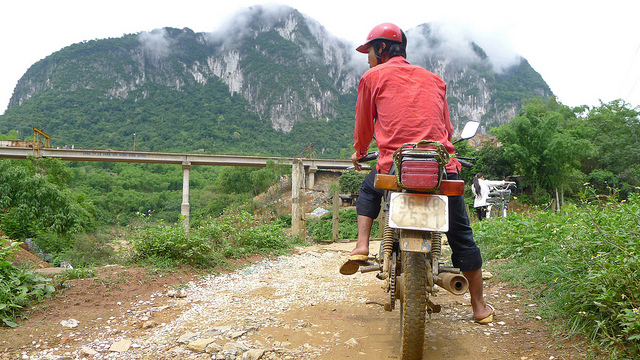

In [ ]:
# Load ImageNet label to category name mapping.
imagenet_categories = [value for key,value in sorted(json.load(open(local_data_dir+'/data_sampled/imagenet_categories.json')).items(), key=lambda t: int(t[0]))]

# Load annotations file for the 20K training images.
mscoco_train = json.load(open(local_data_dir+'/data_sampled/annotations/train2014.json'))
train_ids = [entry['id'] for entry in mscoco_train['images']]
train_id_to_file = {entry['id']: local_data_dir+'/data_sampled/train2014/' + entry['file_name'] for entry in mscoco_train['images']}
category_to_name = {entry['id']: entry['name'] for entry in mscoco_train['categories']}
category_idx_to_name = [entry['name'] for entry in mscoco_train['categories']]
category_to_idx = {entry['id']: i for i,entry in enumerate(mscoco_train['categories'])}

# Load annotations file for the 100 validation images.
mscoco_val = json.load(open(local_data_dir+'/data_sampled/annotations/val2014.json'))
val_ids = [entry['id'] for entry in mscoco_val['images']]
val_id_to_file = {entry['id']: local_data_dir+'/data_sampled/val2014/' + entry['file_name'] for entry in mscoco_val['images']}

# We extract out all of the category labels for the images in the training set. We use a set to ignore
# duplicate labels.
train_id_to_categories = defaultdict(set)
for entry in mscoco_train['annotations']:
    train_id_to_categories[entry['image_id']].add(entry['category_id'])

# We extract out all of the category labels for the images in the validation set. We use a set to ignore
# duplicate labels.
val_id_to_categories = defaultdict(set)
for entry in mscoco_val['annotations']:
    val_id_to_categories[entry['image_id']].add(entry['category_id'])

from IPython.display import Image, display
display(Image(filename=local_data_dir+'/data_sampled/val2014/COCO_val2014_000000391895.jpg'))

Let us take a look at an image and its corresponding category labels. We consider the image with the id 391895 and the corresponding filename, `data/data_sampled/val2014/COCO_val2014_000000391895.jpg`. The image is shown above.

The following code determines the category labels for this image.

In [ ]:
for i,category in enumerate(val_id_to_categories[391895]):
    print("%d. %s" % (i, category_to_name[category]))

0. person
1. bicycle
2. motorcycle


# Loading a Pre-trained Convolutional Neural Network (CNN)

We will work with the VGG-16 image classification CNN network first introduced in [Very Deep Convolutional Neural Networks for Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf) by K. Simonyan and A. Zisserman.

Fairly straightforwardly, we load the pre-trained VGG model and indicate to PyTorch that we are using the model for inference rather than training.

In [ ]:
torch.cuda.is_available()

True

In [ ]:
vgg_model = models.vgg16(pretrained=True).cuda()
vgg_model.eval()

# Let's see what the model looks like.
vgg_model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 426MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Making Predictions Using VGG-16

Given the pre-trained network, we must now write the code to make predictions on the 10 validation images via a forward pass through the network. Typically the final layer of VGG-16 is a softmax layer, however the pre-trained PyTorch model that we are using does not have softmax built into the final layer (instead opting to incorporate it into the loss function) and therefore we must **manually** apply softmax to the output of the function.

In [ ]:
from PIL import Image
softmax = nn.Softmax()
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for image_id in val_ids[:10]:
    # Display the image.
    # -- Your code goes here --
    print("image:" , image_id)
    path = val_id_to_file[image_id]
    img =  Image.open(path).convert('RGB')
    plt.imshow(np.asarray(img))
    plt.show()

    # Print all of the category labels for this image.
    # -- Your code goes here --
    for i,category in enumerate(val_id_to_categories[image_id]):
        print("%d. %s" % (i, category_to_name[category]))

    # Load/preprocess the image.
    img = load_image(val_id_to_file[image_id])
    img = img.to(device)
    vgg_model = vgg_model.to(device)

    # Run the image through the model and softmax.
    label_likelihoods = softmax(vgg_model(img)).squeeze()

    # Get the top 5 labels, and their corresponding likelihoods.
    probs, indices = label_likelihoods.topk(5)

    # Iterate and print out the predictions.
    # -- Your code goes here --
    size = indices.size()[0]
    print("\n labels are: \n")



    imagenet_categories = [value for key,value in sorted(json.load(open(local_data_dir+'/data_sampled/imagenet_categories.json')).items(), key=lambda t: int(t[0]))]
    for i in range(0,size):
        print(imagenet_categories[indices[i].item()])
    print("\n")

Output hidden; open in https://colab.research.google.com to view.

# Computing Generic Visual Features using CNN

Since, rather than the output of VGG, we want a fixed sized vector representation of each image, we remove the last linear layer. The implementation of the forward function for VGG is shown below:

```
x = self.features(x)
x = x.view(x.size(0), -1)
x = self.classifier(x)
```
We aim to preserve everything but the final component of the classifier, meaning we must define an alternative equivalent to `self.classifier`.

In [ ]:
# Remove the final layer of the classifier, and indicate to PyTorch that the model is being used for inference
# rather than training (most importantly, this disables dropout).

# -- Your code goes here --
vgg_model.classifier = nn.Sequential(*list(vgg_model.classifier.children())[:-2]).cuda()

for param in vgg_model.parameters():
    param.requires_grad = False

vgg_model



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# First we vectorize all of the features of training images and write the results to a file.

# -- Your code goes here --
import torch
import torch.nn.functional as F
trainNum = len(train_ids)
training_vectors = np.zeros((trainNum, vgg_model.classifier[3].out_features), dtype=np.float32)  # Ensure dtype is float32

i = 0
for image_id in train_ids[:trainNum]:
    path = train_id_to_file[image_id]
    image = load_image(path)
    # Move the input tensor to the same device as the model's parameters
    image = image.to(device)

    # Run the image through the model and softmax
    label_likelihoods = F.softmax(vgg_model(image),dim=1).squeeze().cpu().data.numpy()

    # Store the features in training_vectors
    training_vectors[i] = label_likelihoods
    i += 1



In [ ]:
output_dir = '/content/drive/MyDrive/Colab Notebooks/6100/W4-Computer Vision Lab/CV-Assignment/data/outputs/'
os.makedirs(output_dir, exist_ok=True)
training_vectors = training_vectors.astype(np.float32)  # Ensure dtype is float32
np.save(os.path.join(output_dir, 'training_vectors.npy'), training_vectors)
print("Finished saving training vectors.")

Finished saving training vectors.


In [ ]:
# Next we vectorize all of the features of validation images and write the results to a file.

# -- Your code goes here --
import torch
import torch.nn.functional as F

valNum = len(train_ids)
validation_vectors = np.zeros((100,vgg_model.classifier[3].out_features),dtype=np.float32)


i=0
for image_id in val_ids[:100]:
    path = val_id_to_file[image_id]
    image = load_image(path)
    image = image.to(device)
    validation_vectors[i] = F.softmax(vgg_model(image),dim=1).squeeze().cpu().data.numpy()
    i += 1


In [ ]:
output_dir = '/content/drive/MyDrive/Colab Notebooks/6100/W4-Computer Vision Lab/CV-Assignment/data/outputs/'
os.makedirs(output_dir, exist_ok=True)
validation_vectors = validation_vectors.astype(np.float32)  # Ensure dtype is float32
np.save(os.path.join(output_dir, 'validation_vectors.npy'), validation_vectors)
print("Finished saving validation vectors.")

Finished saving validation vectors.


# Visual Similarity

We now use the generated vectors, to find the closest training image for each validation image. This can easily be done by finding the training vector that minimizes the Euclidean distance for every validation image. We repeat this exercise for the first 10 images in the validation set.

In [ ]:
# -- Your code goes here --
validation_vectors = np.load(local_data_dir+'/outputs/validation_vectors.npy')
training_vectors = np.load(local_data_dir+'/outputs/training_vectors.npy')
trainNum = np.size(train_ids)


i=0
for image_vid in val_ids[:10]:

    valPath = val_id_to_file[image_vid]
    print("Query Image: \n")
    plt.imshow(np.asarray(Image.open(valPath).convert('RGB')))
    plt.show()

    min = float("inf")
    j = 0
    for image_tid in train_ids[:trainNum]:
        dist = np.linalg.norm(validation_vectors[i,:]-training_vectors[j,:])
        if(dist < min):
            min = dist
            trainPath = train_id_to_file[image_tid]
        j = j+1

    print("Closest Image: \n")
    plt.imshow(np.asarray(Image.open(trainPath).convert('RGB')))
    plt.show()
    i = i+1


Output hidden; open in https://colab.research.google.com to view.

# Training a Multi-Label Classification Network

We now build a two layer classification network, which takes 4096-dimensional vectors as input and outputs the probabilities of the 80 categories present in MSCOCO.

For this purpose, we utilize two layers (both containing sigmoid activation functions) with the hidden dimension set to 512.

In [ ]:
# First we construct a class for the model
# -- Your code goes here --
model= nn.Sequential(
    nn.Linear(4096,512),
    nn.Sigmoid(),
    nn.Linear(512,80),
).cuda()

In [ ]:
trainNum = np.size(train_ids)
labels=np.zeros((trainNum,80))

j=0
for image_id in train_ids[:trainNum]:
    for i,category in enumerate(train_id_to_categories[image_id]):
        labels[j,category_to_idx[category]] = 1
    j=j+1


In [ ]:
val_labels=np.zeros((10,80))

j=0
for image_id in train_ids[:10]:
    for i,category in enumerate(val_id_to_categories[image_id]):
        labels[j,category_to_idx[category]] = 1
    j=j+1

In [ ]:
# The output data is prepared by representing each output as a binary vector of categories
# -- Your code goes here --
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import math

# Assuming you have defined your model class and other necessary components.

def train(model, learning_rate=0.001, batch_size=100, epochs=5):
    optimizer = optim.Adam(model.parameters(), learning_rate)
    criterion = nn.MultiLabelSoftMarginLoss()

    # Assuming trainNum is defined
    batch_num = math.floor(trainNum / batch_size)

    for epoch in range(epochs):
        losses = []
        for i in range(batch_num):
            input_data = torch.from_numpy(np.asarray(training_vectors[i * batch_size:(i + 1) * batch_size])).float().cuda()
            optimizer.zero_grad()
            yhat = model(Variable(input_data))

            true_labels = Variable(torch.from_numpy(np.asarray(labels[i * batch_size:(i+1)*batch_size])).float()).cuda()
            loss = criterion(yhat, true_labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())  # Use item() to get Python number from a tensor

        print('[%d/%d] Loss: %.3f' % (epoch+1, epochs, np.mean(losses)))

# Assuming you have defined your model earlier

# Finally train the model
train(model)


[1/5] Loss: 0.137
[2/5] Loss: 0.136
[3/5] Loss: 0.136
[4/5] Loss: 0.136
[5/5] Loss: 0.135


In [ ]:
# Test the accuracy
# -- Your code goes here --
model.eval()
i = 0
for image_id in val_ids[:10]:
    # Display the image.
    print("image:" , image_id)
    path = val_id_to_file[image_id]
    img =  Image.open(path).convert('RGB')
    plt.imshow(np.asarray(img))
    plt.show()

    # Print all of the category labels for this image.
    for i,category in enumerate(val_id_to_categories[image_id]):
        print("%d. %s" % (i, category_to_name[category]))

    # Load/preprocess the image.
    feature_vector = validation_vectors[i]

    # Run the image through the model and softmax.

    feature_vector = Variable(torch.from_numpy(np.asarray(feature_vector)).float()).cuda()
    modelOutput = model(feature_vector)
    label_likelihoods = torch.sigmoid(modelOutput).squeeze().cuda()

    # Get the top 5 labels, and their corresponding likelihoods.
    probs, indices = label_likelihoods.topk(5)

    # Iterate and print out the predictions.
    size = indices.size()[0]

    print(probs)

    print("\n labels are: \n")

    for i in range(0,size):
        print(category_idx_to_name[indices[i].item()])
    print("\n")

    i = i+1


Output hidden; open in https://colab.research.google.com to view.

# End-to-End Model Fine-tuning

Instead of training *only* the final two layers, we now create an end-to-end model and train the entire thing.

In [ ]:
# First we construct a class for the model
# -- Your code goes here --
full_model = models.vgg16(pretrained=True).cuda()
dropout = nn.Sequential(nn.Dropout(p=0.5)).cuda()
full_model.classifier = nn.Sequential(*list(full_model.classifier.children())[:-2] + list(dropout.children()) + list(model.children())).cuda()

full_model.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# The output data is prepared by representing each output as a binary vector of categories
# -- Your code goes here --

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import math

# Assuming you have defined your model, training data, and labels

def train(model, train_ids, train_id_to_file, labels, learning_rate=0.001, batch_size=50, epochs=2):
    optimizer = optim.Adam(model.parameters(), learning_rate)
    criterion = nn.MultiLabelSoftMarginLoss()

    train_num = len(train_ids)
    batch_num = math.ceil(train_num / batch_size)

    for epoch in range(epochs):
        losses = []

        for i in range(batch_num):
            images = []

            for image_id in train_ids[i * batch_size:(i + 1) * batch_size]:
                reshaped_image = load_image(train_id_to_file[image_id]).reshape(3, 224, 224)

                images.append(reshaped_image)

            images_tensor = torch.stack(images, dim=0).cuda()

            yhat = model(images_tensor).squeeze()

            optimizer.zero_grad()
            true_labels = torch.from_numpy(np.asarray(labels[i * batch_size:(i + 1) * batch_size])).float().cuda()
            loss = criterion(yhat, true_labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        print('[%d/%d] Loss: %.3f' % (epoch + 1, epochs, np.mean(losses)))

# Assuming you have defined your model as 'full_model'

# Finally, train the model
train(full_model, train_ids, train_id_to_file, labels)


[1/2] Loss: 0.141
[2/2] Loss: 0.138


In [ ]:
# Test
# -- Your code goes here --
full_model.eval()
i = 0
for image_id in val_ids[:10]:
    # Display the image.
    print("image:" , image_id)
    path = val_id_to_file[image_id]
    img =  Image.open(path).convert('RGB')
    plt.imshow(np.asarray(img))
    plt.show()

    # Print all of the category labels for this image.
    for i,category in enumerate(val_id_to_categories[image_id]):
        print("%d. %s" % (i, category_to_name[category]))

    # Load/preprocess the image.
    feature_vector = validation_vectors[i]

    # Run the image through the model and softmax.

    img = load_image(val_id_to_file[image_id]).cuda()

    modelOutput = full_model(img)
    label_likelihoods = torch.sigmoid(modelOutput).squeeze().cuda()

    # Get the top 5 labels, and their corresponding likelihoods.
    probs, indices = label_likelihoods.topk(5)

    # Iterate and print out the predictions.
    size = indices.size()[0]

    print(probs)

    print("\n labels are: \n")

    for i in range(0,size):
        print(category_idx_to_name[indices[i].item()])
    print("\n")

    i = i+1

Output hidden; open in https://colab.research.google.com to view.

# Hyper-parameter Tuning

Now we do a grid search over the learning rate and batch size.

train loss 0:0.161678
val loss 0:0.261473
train loss 1:0.155169
val loss 1:0.280543
train loss 2:0.152097
val loss 2:0.151821
train loss 3:0.152626
val loss 3:0.274769
train loss 4:0.150596
val loss 4:0.107594
train loss 5:0.150191
val loss 5:0.116837
train loss 6:0.149481
val loss 6:0.135768
train loss 7:0.149517
val loss 7:0.110989
train loss 8:0.149263
val loss 8:0.153795
train loss 9:0.148703
val loss 9:0.171159
train loss 10:0.148471
val loss 10:0.143271
train loss 11:0.148309
val loss 11:0.208657
train loss 12:0.148264
val loss 12:0.158578
train loss 13:0.148244
val loss 13:0.117469
train loss 14:0.148661
val loss 14:0.131533
train loss 15:0.148915
val loss 15:0.121456
train loss 16:0.148688
val loss 16:0.123106
train loss 17:0.148963
val loss 17:0.109353
train loss 18:0.148859
val loss 18:0.150984
train loss 19:0.148795
val loss 19:0.140632


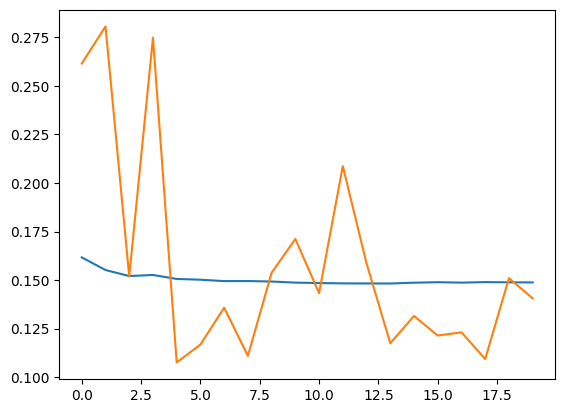

In [ ]:

def train_hyparameters(model, learning_rate, batch_size, epochs=1):
    """
    Training function which takes as input a model, a learning rate and a batch size.

    After completing a full pass over the data, the function exists, and the input model will be trained.
    """
    optimizer = optim.Adam(model.parameters(),learning_rate)
    criterion = nn.MultiLabelSoftMarginLoss().cuda()

    batchNum = math.floor(trainNum / batch_size)
    plot_x = math.floor(trainNum/1000)
    plot_y = np.zeros(plot_x)
    plot2_y = np.zeros(plot_x)
    plotCounter = 0

    for epoch in range(0, epochs):

        losses = []
        batchIndex = 0

        for i in range(0, batchNum):

            model.train()

            batchIndex =  (i+1) * batch_size
            images = []

            for image_id in train_ids[i * batch_size:(i+1)*batch_size]:
                images.append(load_image2(train_id_to_file[image_id]))

            yhat = model(torch.stack(images, dim = 0)).squeeze().cuda()

            optimizer.zero_grad()
            TrueLabel =  Variable(torch.from_numpy(np.asarray(labels[i * batch_size:(i+1)*batch_size])).float()).cuda()
            loss = criterion(yhat, TrueLabel)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

            if (batchIndex % 1000 == 0):
                plot_y[plotCounter] = np.mean(losses)
                print('train loss %d:%f' % (plotCounter,plot_y[plotCounter]))

                model.eval()

                val_images = []
                for image_id in val_ids[:10]:
                    val_images.append(load_image2(val_id_to_file[image_id]))
                val_yhat = model(torch.stack(val_images, dim = 0)).squeeze().cuda()
                val_TrueLabel =  Variable(torch.from_numpy(np.asarray(val_labels[1:10])).float()).cuda()
                val_loss = criterion(yhat, TrueLabel)
                val_meanLoss = val_loss.data.mean()
                plot2_y[plotCounter] = val_meanLoss
                print('val loss %d:%f' % (plotCounter,plot2_y[plotCounter]))
                plotCounter = plotCounter + 1



        #lossMean = np.mean(losses)
        #print('Loss: %.3f' % (lossMean))
        plt.plot(range(0,plot_x), plot_y)
        plt.plot(range(0,plot_x), plot2_y)

hyper_model1 = train_hyparameters(full_model,0.001,10)


train loss 0:0.151322
val loss 0:0.230107
train loss 1:0.146023
val loss 1:0.208555
train loss 2:0.142853
val loss 2:0.154998
train loss 3:0.143379
val loss 3:0.194264
train loss 4:0.141863
val loss 4:0.127820
train loss 5:0.141503
val loss 5:0.136994
train loss 6:0.141054
val loss 6:0.124421
train loss 7:0.141224
val loss 7:0.117331
train loss 8:0.140979
val loss 8:0.129344
train loss 9:0.140512
val loss 9:0.134496
train loss 10:0.140362
val loss 10:0.119050
train loss 11:0.140203
val loss 11:0.159682
train loss 12:0.140162
val loss 12:0.124720
train loss 13:0.140094
val loss 13:0.121716
train loss 14:0.140345
val loss 14:0.107425
train loss 15:0.140566
val loss 15:0.131416
train loss 16:0.140426
val loss 16:0.121904
train loss 17:0.140729
val loss 17:0.114238
train loss 18:0.140675
val loss 18:0.168008
train loss 19:0.140639
val loss 19:0.152547


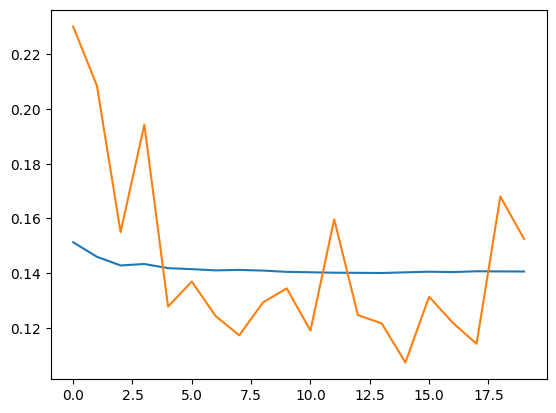

In [ ]:
hyper_model2 = train_hyparameters(full_model,0.001,25)

train loss 0:0.147374
val loss 0:0.182319
train loss 1:0.143583
val loss 1:0.183668
train loss 2:0.140459
val loss 2:0.148958
train loss 3:0.141093
val loss 3:0.166161
train loss 4:0.139714
val loss 4:0.106425
train loss 5:0.139345
val loss 5:0.134862
train loss 6:0.138888
val loss 6:0.116084
train loss 7:0.139093
val loss 7:0.113990
train loss 8:0.138865
val loss 8:0.124293
train loss 9:0.138451
val loss 9:0.130273
train loss 10:0.138276
val loss 10:0.119544
train loss 11:0.138110
val loss 11:0.137033
train loss 12:0.138034
val loss 12:0.120619
train loss 13:0.137981
val loss 13:0.126553
train loss 14:0.138236
val loss 14:0.103246
train loss 15:0.138504
val loss 15:0.120541
train loss 16:0.138371
val loss 16:0.122719
train loss 17:0.138739
val loss 17:0.131055
train loss 18:0.138670
val loss 18:0.147564
train loss 19:0.138650
val loss 19:0.159256


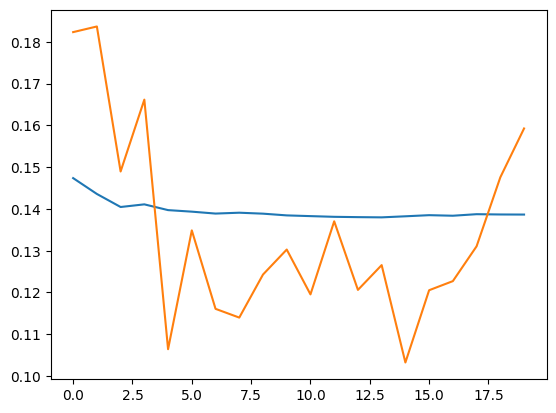

In [ ]:
hyper_model3 = train_hyparameters(full_model,0.001,50)

train loss 0:0.145100
val loss 0:0.249238
train loss 1:0.141541
val loss 1:0.257270
train loss 2:0.138709
val loss 2:0.139275
train loss 3:0.139373
val loss 3:0.254805
train loss 4:0.138021
val loss 4:0.097497
train loss 5:0.137760
val loss 5:0.109229
train loss 6:0.137315
val loss 6:0.125886
train loss 7:0.137559
val loss 7:0.102998
train loss 8:0.137386
val loss 8:0.146418
train loss 9:0.137006
val loss 9:0.147621
train loss 10:0.136798
val loss 10:0.119698
train loss 11:0.136665
val loss 11:0.189660
train loss 12:0.136611
val loss 12:0.148049
train loss 13:0.136579
val loss 13:0.109993
train loss 14:0.136845
val loss 14:0.109532
train loss 15:0.137073
val loss 15:0.106921
train loss 16:0.136921
val loss 16:0.116137
train loss 17:0.137252
val loss 17:0.099615
train loss 18:0.137201
val loss 18:0.141336
train loss 19:0.137175
val loss 19:0.138778


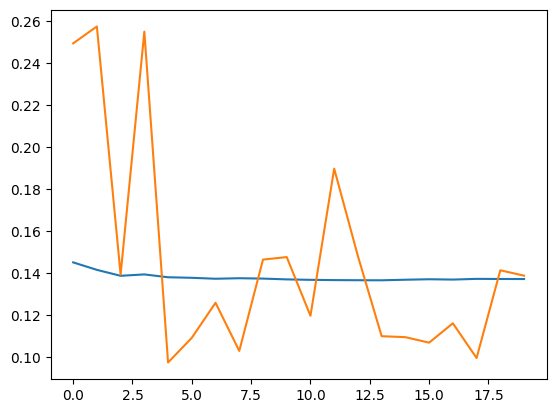

In [69]:
hyper_model4 = train_hyparameters(full_model,0.0001,10)

train loss 0:0.143205
val loss 0:0.229263
train loss 1:0.140152
val loss 1:0.204758
train loss 2:0.137598
val loss 2:0.148026
train loss 3:0.138366
val loss 3:0.197277
train loss 4:0.137071
val loss 4:0.112529
train loss 5:0.136859
val loss 5:0.125645
train loss 6:0.136425
val loss 6:0.116995
train loss 7:0.136708
val loss 7:0.114941
train loss 8:0.136573
val loss 8:0.125034
train loss 9:0.136228
val loss 9:0.134722
train loss 10:0.136002
val loss 10:0.110800
train loss 11:0.135881
val loss 11:0.154898
train loss 12:0.135840
val loss 12:0.117242
train loss 13:0.135804
val loss 13:0.113482
train loss 14:0.136082
val loss 14:0.104228
train loss 15:0.136318
val loss 15:0.130747
train loss 16:0.136184
val loss 16:0.120909
train loss 17:0.136513
val loss 17:0.112635
train loss 18:0.136461
val loss 18:0.166989
train loss 19:0.136432
val loss 19:0.148085


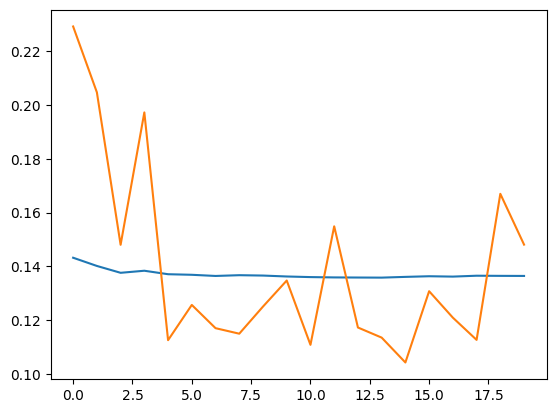

In [70]:
hyper_model5 = train_hyparameters(full_model,0.0001,25)

train loss 0:0.142997
val loss 0:0.185271
train loss 1:0.139943
val loss 1:0.177180
train loss 2:0.137430
val loss 2:0.145353
train loss 3:0.138178
val loss 3:0.168210
train loss 4:0.136936
val loss 4:0.106695
train loss 5:0.136725
val loss 5:0.130711
train loss 6:0.136264
val loss 6:0.113844
train loss 7:0.136536
val loss 7:0.113163
train loss 8:0.136394
val loss 8:0.122917
train loss 9:0.136044
val loss 9:0.127550
train loss 10:0.135825
val loss 10:0.117725
train loss 11:0.135708
val loss 11:0.134343
train loss 12:0.135670
val loss 12:0.118338
train loss 13:0.135637
val loss 13:0.122513
train loss 14:0.135917
val loss 14:0.102857
train loss 15:0.136155
val loss 15:0.121601
train loss 16:0.136027
val loss 16:0.121304
train loss 17:0.136348
val loss 17:0.129748
train loss 18:0.136294
val loss 18:0.146038
train loss 19:0.136264
val loss 19:0.154022


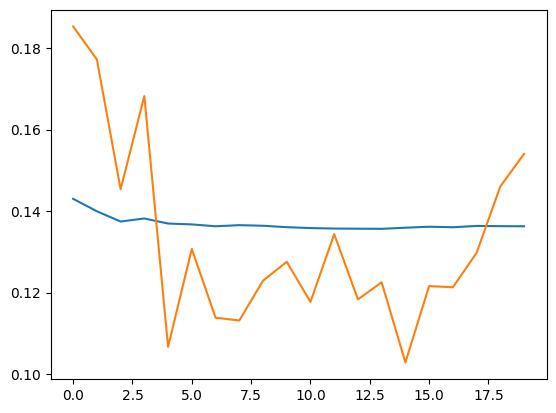

In [71]:
hyper_model6 = train_hyparameters(full_model,0.0001,50)

train loss 0:0.142632
val loss 0:0.257585
train loss 1:0.139724
val loss 1:0.251060
train loss 2:0.137180
val loss 2:0.137445
train loss 3:0.137881
val loss 3:0.258874
train loss 4:0.136630
val loss 4:0.098160
train loss 5:0.136421
val loss 5:0.109162
train loss 6:0.136014
val loss 6:0.122893
train loss 7:0.136278
val loss 7:0.103840
train loss 8:0.136188
val loss 8:0.145417
train loss 9:0.135861
val loss 9:0.148194
train loss 10:0.135624
val loss 10:0.123138
train loss 11:0.135515
val loss 11:0.193115
train loss 12:0.135484
val loss 12:0.145271
train loss 13:0.135463
val loss 13:0.108620
train loss 14:0.135739
val loss 14:0.107257
train loss 15:0.135982
val loss 15:0.108223
train loss 16:0.135843
val loss 16:0.122196
train loss 17:0.136164
val loss 17:0.099079
train loss 18:0.136117
val loss 18:0.139126
train loss 19:0.136086
val loss 19:0.136485


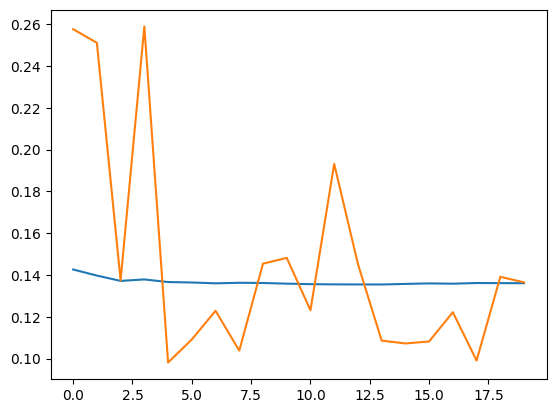

In [72]:
hyper_model7 = train_hyparameters(full_model,0.00001,10)

train loss 0:0.142435
val loss 0:0.231573
train loss 1:0.139522
val loss 1:0.205094
train loss 2:0.137016
val loss 2:0.147631
train loss 3:0.137700
val loss 3:0.195950
train loss 4:0.136456
val loss 4:0.116924
train loss 5:0.136267
val loss 5:0.126552
train loss 6:0.135876
val loss 6:0.115334
train loss 7:0.136171
val loss 7:0.114816
train loss 8:0.136065
val loss 8:0.123417
train loss 9:0.135731
val loss 9:0.133660
train loss 10:0.135508
val loss 10:0.113123
train loss 11:0.135399
val loss 11:0.153609
train loss 12:0.135355
val loss 12:0.116278
train loss 13:0.135334
val loss 13:0.112820
train loss 14:0.135616
val loss 14:0.103109
train loss 15:0.135859
val loss 15:0.131152
train loss 16:0.135721
val loss 16:0.122641
train loss 17:0.136036
val loss 17:0.112129
train loss 18:0.135984
val loss 18:0.167108
train loss 19:0.135958
val loss 19:0.147668


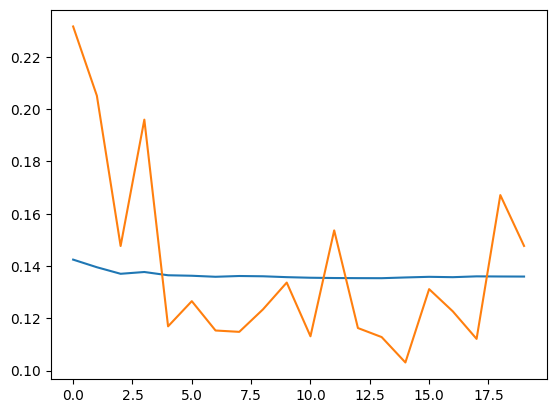

In [73]:
hyper_model8 = train_hyparameters(full_model,0.00001,25)

train loss 0:0.142533
val loss 0:0.185055
train loss 1:0.139511
val loss 1:0.177644
train loss 2:0.136959
val loss 2:0.145420
train loss 3:0.137685
val loss 3:0.167199
train loss 4:0.136473
val loss 4:0.107853
train loss 5:0.136300
val loss 5:0.132501
train loss 6:0.135897
val loss 6:0.114323
train loss 7:0.136160
val loss 7:0.112743
train loss 8:0.136072
val loss 8:0.123666
train loss 9:0.135759
val loss 9:0.127488
train loss 10:0.135519
val loss 10:0.118583
train loss 11:0.135406
val loss 11:0.134115
train loss 12:0.135369
val loss 12:0.117354
train loss 13:0.135345
val loss 13:0.121919
train loss 14:0.135624
val loss 14:0.102299
train loss 15:0.135859
val loss 15:0.120230
train loss 16:0.135720
val loss 16:0.121934
train loss 17:0.136035
val loss 17:0.129334
train loss 18:0.135984
val loss 18:0.145270
train loss 19:0.135952
val loss 19:0.153562


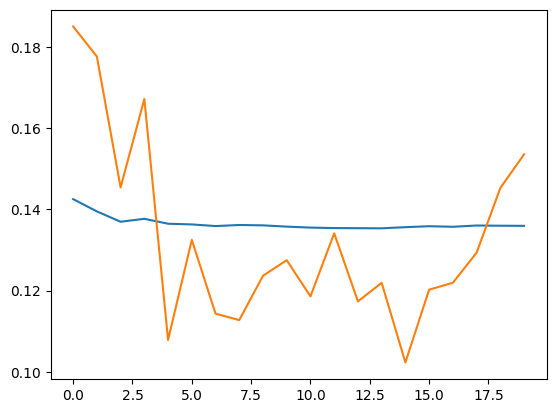

In [ ]:
hyper_model9 = train_hyparameters(full_model,0.00001,50)